In [1]:
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage

import fastai.vision.all as fv
from fastai.callback.hook import hook_outputs

from fastprogress.fastprogress import progress_bar

In [2]:
to_pil = ToPILImage()
to_tensor = ToTensor()

In [3]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None, :, None, None]
        self.std = torch.tensor(std)[None, :, None, None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s
    
def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [4]:
!ls /notebooks/storage/

data  photo5095913533916424372.jpg  photo5095913533916424373.jpg  re_and_mul


In [5]:
size = (256,384)

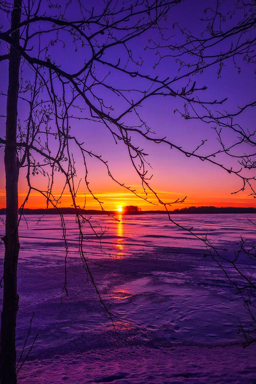

In [6]:
content_img = fv.PILImage.create("/notebooks/storage/photo5095913533916424373.jpg").resize(size)
content_img

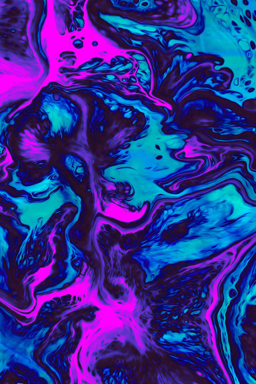

In [7]:
style = fv.PILImage.create("/notebooks/storage/photo5095913533916424372.jpg").resize(size)
style

In [8]:
content_tensor = Normalizer()(to_tensor(content_img)[None]).cuda()
style_tensor = Normalizer()(to_tensor(style)[None]).cuda()
content_tensor.requires_grad=True
style_tensor.requires_grad=True

In [9]:
def denorm(t):
    mean,sd = (torch.tensor(x) for x in fv.imagenet_stats)
    mean,sd = mean[:,None,None],sd[:,None,None]
    return mean + t*sd

def view(t):
    t = t.detach().cpu()
    if len(t.shape) == 4:
        t = t[0]
    return to_pil(denorm(t).clamp(0,1))

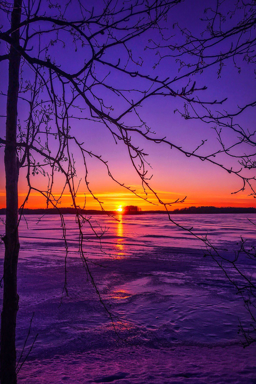

In [10]:
content_tensor = content_tensor.cuda();view(content_tensor)

In [14]:
def cm(x):
    a,b,c,d = x.shape
    x = x.view(a, b, c*d)
    return (x @ x.transpose(1,2))/(b*c*d)


class StyleAndContentLoss(nn.Module):
    def __init__(self, model, layer_ids, content_weights=[1,3,8,12,20,10], style_weights=[20,25,15,10,4], style_mult=8e3):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.style_mult = style_mult
        
    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone: 
            features = [f.clone() for f in features]
            
        return features

    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(cm(a), cm(b))*w for a,b,w in zip(A,B,self.style_weights)])
    
    def forward(self, x, style_image):
        x_features = self.extract_features(x)
        style_features = self.extract_features(style_image, clone=True)
        
        self.SL = self.style_mult*self.style_loss(x_features, style_features)
        
        return self.SL

    def __del__(self):
        self.hooks.remove()
        

def scl(**kwargs):
    vgg = fv.vgg16_bn(pretrained=True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,o in enumerate(vgg.children()) if isinstance(o, nn.MaxPool2d)]
    
    return StyleAndContentLoss(vgg, layer_ids=good_blocks, **kwargs)

In [15]:
content_and_style_loss = scl().cuda()
optimizer = torch.optim.Adam([content_tensor], lr=1e-1)

In [16]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(content_tensor, style_tensor)
    pbar.comment = f" total_loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

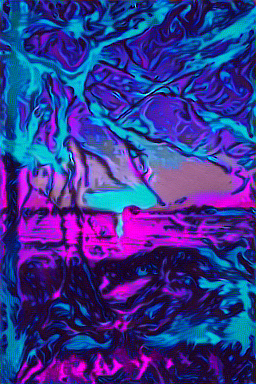

In [17]:
view(content_tensor)